# Ground Truth

## Introduction
In this Jupyter Notebook we determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE).

## How To Run
Please refer to the README file in this repository for a tutorial on how to set up GEE. Additionally you need a "../data/interim/plot.csv" file with columns:
```python
{
    "conifer": 0 <= int <= 1,
    "date": str,
    "dbh": 0 < float,
    "latitude": float,
    "longitude": float
}
```
Then you can run the notebook using **Run All** in your IDE.

# Preprocessing
The ground truth label is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/target.tif" for the leaf type mixture label. The raster "data/processed/target_area.tif" contains the base area per leaf type.

This notebook loads the dataset, analyzes it and creates two rasters from it. One raster contains the conifer proportion, the other raster contains the absolute base area per pixel per leaf type.

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")
gdf

,conifer,date,dbh,geometry
0,0,2015-09-13,0.190,POINT (326154.538 5311966.490)
1,0,2015-09-13,0.131,POINT (326154.127 5311966.090)
2,0,2015-09-13,0.230,POINT (326151.683 5311967.751)
3,0,2015-09-13,0.286,POINT (326146.318 5311967.072)
4,1,2015-09-13,0.183,POINT (326144.652 5311964.678)
...,...,...,...,...
15706,1,2016-03-16,0.303,POINT (325101.805 5311657.948)
15707,0,2016-03-16,0.770,POINT (325103.513 5311653.484)
15708,1,2016-03-16,0.670,POINT (325105.042 5311653.988)
15709,0,2016-03-16,0.583,POINT (325110.022 5311652.609)


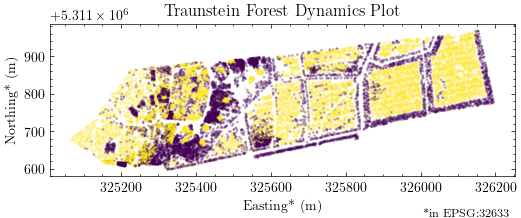

In [2]:
# Plot the data on stem level
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = gdf.plot(markersize=1, figsize=(6, 2), alpha=0.25, column="conifer", cmap="viridis")
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
ax.annotate(
    "*in EPSG:32633",
    (ax.get_position().x1 - 0.05, 0),
    xycoords="figure fraction",
    va="bottom",
    ha="right",
    fontsize="small",
)
fig = ax.get_figure()
plt.show()

First sample: 2015-03-11
Last sample: 2016-04-13


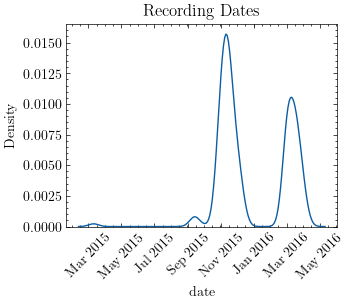

In [3]:
# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"], label="Recording Dates KDE")
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.show()

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label
from pathlib import Path

gt_path = "../data/processed/"
Path(gt_path).mkdir(parents=True, exist_ok=True)

target_path = gt_path + "target.tif"
target_area_path = gt_path + "target_area.tif"

if not Path(target_path).exists():
    compute_label(target_path=target_path, plot=df)

if not Path(target_area_path).exists():
    compute_label(target_path=target_area_path, plot=df, area_as_target=True)

Initializing Earth Engine API...
Preparing labels...
Computing labels...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

GeoTIFF saved as ../data/processed/target.tif
Preparing labels...
Computing labels...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

GeoTIFF saved as ../data/processed/target_area.tif


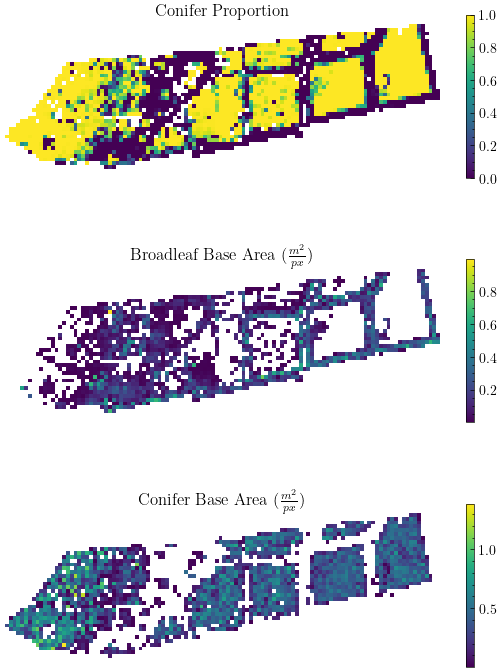

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import rasterio
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open(target_path) as src:
    # Plot the broadleaf content
    target = src.read(1)

    img = axes[0].imshow(target, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Conifer Proportion")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open(target_area_path) as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)
    broadleaf_area[broadleaf_area == 0] = np.nan

    img = axes[1].imshow(
        broadleaf_area, cmap="viridis", interpolation="nearest"
    )
    axes[1].set_title(r"Broadleaf Base Area ($\frac{m^2}{px}$)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)
    conifer_area[conifer_area == 0] = np.nan

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title(r"Conifer Base Area ($\frac{m^2}{px}$)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

plt.show()

# Sentinel 2 Data

The Sentinel 2 data corresponding to the target label is generated using the Google Earth Engine. The data is filtered by the plot boundaries and a specified time range. The data is then reduced to the temporal resolution of the ground truth data. The data is then exported to a GeoTIFF file.

We prefer using the [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) dataset, as it is atmospherically corrected and harmonized, shifting data in newer scenes to a range comparable to older scenes. However the [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED) dataset is available for all Sentinel 2 imagery, starting at 27th of june 2015 while Level 2A data is only available since 28th of march 2017.

To decide which dataset to use, we compare the two datasets. We use a time range of one year, starting at july 1st 2015 for the Level 1C data. The time range of a year starting at april 1st 2017 is used for the Level 2A data. We then compare the two datasets by cross validating a random forest with default parameters using Scikit-Learn and the root mean squared error.

In [6]:
# Create Level 1C and 2A imagery
from ltm.data import sentinel_composite
from datetime import datetime
from pathlib import Path
from sklearn.metrics import make_scorer, root_mean_squared_error
from ltm.features import load_raster, drop_nan_rows
from sklearn.model_selection import cross_validate

rmse_scorer = make_scorer(root_mean_squared_error)
level_1c_path = "../data/processed/ground_truth/data_1C.tif"
level_2a_path = "../data/processed/ground_truth/data_2A.tif"
target_path = "../data/processed/target.tif"

# Create the 1C composite if it does not exist
if not Path(level_1c_path).exists():
    Path(level_1c_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=level_1c_path,
        time_window=(datetime(2015, 7, 1), datetime(2016, 7, 1)),
        level_2a=False,
    )

# Create the 2A composite if it does not exist
if not Path(level_2a_path).exists():
    Path(level_2a_path).parent.mkdir(parents=True, exist_ok=True)
    sentinel_composite(
        target_path_from=target_path,
        data_path_to=level_2a_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
    )

In [7]:
# Compare it to the baseline
from sklearn.ensemble import RandomForestRegressor

# Load data
level_1c_data = load_raster(level_1c_path)
level_2a_data = load_raster(level_2a_path)
target = load_raster(target_path)

# Drop NaN rows
level_1c_data, _ = drop_nan_rows(level_1c_data, target)
level_2a_data, target = drop_nan_rows(level_2a_data, target)

# Cross validate Random Forest on Level 1C data
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)
level_1c_result = cross_validate(
    rf_regressor, level_1c_data, target, cv=5, scoring=rmse_scorer, n_jobs=-1
)
level_1c_score = level_1c_result["test_score"].mean()

# Cross validate Random Forest on Level 2A data
level_2a_result = cross_validate(
    rf_regressor, level_2a_data, target, cv=5, scoring=rmse_scorer, n_jobs=-1
)
level_2a_score = level_2a_result["test_score"].mean()

# Print scores
print(f"Level 1C RMSE: {level_1c_score}")
print(f"Level 2A RMSE: {level_2a_score}")

Level 1C RMSE: 0.3061696264126286
Level 2A RMSE: 0.3060081806966466


As our preference is Level 2A data and the RMSE is slightly lower, we will continue with the Level 2A data.